<center>
<h1>An introduction to your project</h1>
<h4>John F. Wu, *Rutgers University*</h4>
<br>Jupyter notebooks (or IPython notebooks) can be used not only for executing python code, but also for taking notes via [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and entering $\LaTeX$ commands. This document is intended to give you an idea of what a Jupyter notebook looks like and how it works, and hopefully illustrate some of the data set you'll be working with. You may find some of the code in here useful for your project.
</center>


## I. Getting started

At this point you've probably got Python and Jupyter notebook installed. If you're running Ubuntu or Linux Mint or a similar Debian-based distro, you can install a bunch of useful packages quickly by running in your shell:

    sudo apt-get install libblas-dev liblapack-dev libatlas-base-dev
    sudo apt-get install python-pip && \
         pip install --upgrade scipy numpy matplotlib astropy pandas seaborn ipython notebook
         
The first line uses Ubuntu's `apt-get`, a (program) package handler, to install a few linear algebra libraries for optimized computation. The second line downloads pip (a python package manager) and then uses it to install/upgrade a few python packages that I find useful for day-to-day research.


In the directory that I've sent you, you should see a bunch of files structured as below:
    
    for_manuel
    ├── aat_2015
    │   ├── G13_NOAO0334_v09_07.fits
    │   ├── G14_NOAO0334_v09_07.fits
    │   ├── G15_NOAO0334_v09_07.fits
    │   ├── G16_NOAO0334_v09_09.fits
    │   ├── G17_NOAO0334_v09_10.fits
    │   ├── G18_NOAO0334_v09_10.fits
    │   ├── G19_NOAO0334_v09_10.fits
    │   └── laduma_2015_master.marz.cat
    ├── notebook
    │   └── Introduction to your project.ipynb
    └── start.py


The files in the `aat_2015` directory are spectra taken by Ángel López-Sánchez and me in December of 2015. They're in the FITS file format, which stands for *Flexible Image Transport System*. FITS files are a standard way of storing astronomical observations--including spectroscopy, photometry, multi-dimensional data cubes, as well as tables.

There's also the directory `notebook`, in which this document resides, and also a program `start.py`, which covers some of what this document will explain. I'm hoping that this is enough to help you get started!

A good way to open up the aforementioned FITS files is by using the python package `astropy` (I'll also use `numpy` for numerical/array operations). I'll demonstrate below:

In [1]:
import numpy as np
from astropy.io import fits

# hdulist is a Header Data Unit List
hdulist = fits.open('../aat_2015/G16_NOAO0334_v09_09.fits')

print hdulist.info()

Filename: ../aat_2015/G16_NOAO0334_v09_09.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     177   (5037, 400)   float32   
1    VARIANCE    ImageHDU         8   (5037, 400)   float32   
2    FIBRES      BinTableHDU    106   400R x 17C   [80A, 1D, 1D, 1J, 1J, 1I, 1I, 1D, 1A, 1I, 1D, 1J, 80A, 10A, 1D, 1D, 1D]   
3    NDF_CLASS   BinTableHDU     14   1R x 1C      [8A]   
4    SHIFTS      ImageHDU         8   (400, 10)    float32   
5    THPUT       ImageHDU         7   (400,)       float32   
6    RWSS        ImageHDU         8   (2048, 400)   float32   
7    SKY         ImageHDU         7   (5037,)      float32   
8    TELCOR      ImageHDU         7   (2048,)      float32   
9    REDUCTION_ARGS  TableHDU        15   100R x 2C    [A16, A32]   
10   REDUCED     BinTableHDU     11   1R x 1C      [1L]   
None


## II. Examining the HDU header

From the output above, we can see that there are quite a few HDUs, or Header Data Units, within the FITS file. They are useful information, but for now, we care about the PrimaryHDU located at index 0. That one contains 177 *cards* in the *header*: each card is a keyword-value pair.

In [2]:
header = hdulist[0].header
header_keys = header.keys()

# show the first five keys in the PrimaryHDU header
print header_keys[0:5]

['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2']


It is also simple to access the values corresponding to header keys (or keywords):

In [3]:
# prints the date of the observation in the format YYYY:MM:DD
print 'Observations were taken on', header['UTDATE']    

# prints the len of axis 1 and axis 2 in the data (i.e., number of rows and columns)
print 'This HDU has dimensions of {0:d} by {1:d}.'.format(header['NAXIS1'], header['NAXIS2'])

Observations were taken on 2015:12:09
This HDU has dimensions of 5037 by 400.


If we look up a few cells, we can see that the PrimaryHDU has not only 177 cards in the header, but also dimensions of (5037, 400) in the *data* part. This is what exactly what we found by accessing the header. Each element in this 5037 x 400 matrix is a [32-bit floating point number](https://en.wikipedia.org/wiki/Single-precision_floating-point_format), which is why `float32` is shown under the `Format` column.

Now let's open up the data. It has 5037 columns, one corresponding to each wavelength in the spectrum, and 400 rows, one corresponding to a spectroscopic fiber on the 2dF fiber-positioner of the Anglo-Australian Telescope (AAT).<sup><a href="#1">1</a></sup>

## III. Working with the spectra

In [4]:
# First let's access the data:
spectra = hdulist[0].data

# It should be 5037 columns x 400 rows
print spectra.shape 

(400, 5037)


Wait, hold on. Did the axes just switch from before?--the FITS HDUlist said that the dimensions were (5037, 400)!

The answer is simple: FITS files, which origniated in the era of Fortran, are in *column-major* order. Simply put, they label matrices and arrays by (column, row). However, python is in *row-major* order, and so when we load in the data, it thinks that the shape should be (row, column). In both cases, the actual data are consistent, but the presentation may vary... just be careful and know what you're working with.<sup><a href="#2">2</a></sup> Note that not all 400 rows will be filled with data; however, each FITS file should contain 400 rows (even if some are filled with `nan` values).

### III*a*. Calibrating the spectral wavelengths

The 5037 pixels along axis 1 must be scaled to actual units; for example, they might begin at 3750 Å and be spaced at intervals of 1.5 Å. We want to create a 5037-element long one dimensional array called `wavelengths` that maps the pixel number (i.e., 0, 1, 2, 3, ..., 5036) to observed wavelengths (e.g., in units of angstroms: 3750, 3751.5, 3753, ...).

In order to find this out, we'll make use of the `CRVAL1` and the `CDELT1` header keywords, which respectively tell us the central wavelength and the $\Delta \lambda$ in whatever unit is specified by the `CUNIT1` card.

In [5]:
# ensure we know what units the wavelengths are in
print 'The wavelengths are in units of {}.'.format(header['CUNIT1'].lower())

# figure out what the central wavelength is at the center "pixel" of axis 1
print 'At center pixel {:.0f}, the wavelength value is {:.2f} angstroms.'.format(header['CRPIX1'], header['CRVAL1'])

# figure out how the wavelengths increment
print 'Each wavelength increments by {:.2f} angstroms per pixel.'.format(header['CDELT1'])

The wavelengths are in units of angstroms.
At center pixel 2518, the wavelength value is 6365.18 angstroms.
Each wavelength increments by 1.04 angstroms per pixel.


In [6]:
# Scale, or calibrate, the wavelengths to the right units
wavelengths = np.arange(header['NAXIS1']) - header['CRPIX1']
wavelengths = wavelengths * header['CDELT1'] + header['CRVAL1']

print 'The wavelength range spans between {:.2f} and {:.2f} angstroms.'.format(min(wavelengths), max(wavelengths))

The wavelength range spans between 3752.38 and 8977.99 angstroms.


### III*b*. A first look at the spectra

At this point, we can start looking at the different galaxy spectra as a function of wavelength. It's not clear what units the fluxes are in, so for now we'll just keep them as is and consider them to be in arbitrary units. Below, we'll plot a single spectrum (note that I'm using `seaborn` and `matplotlib` to make the visualization easier, and I also use the `@matplotlib inline` IPython magic function to plot within the document).

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


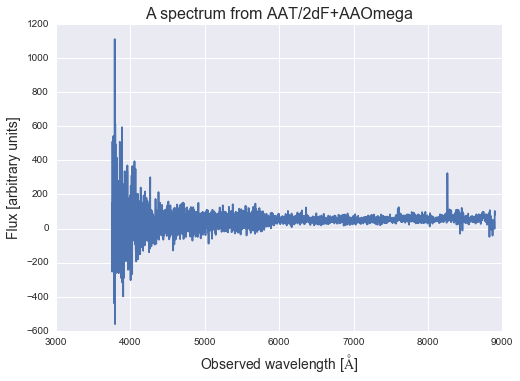

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid')

# select first spectrum
spectrum = spectra[0]
plt.plot(wavelengths, spectrum)

plt.xlabel(r'Observed wavelength [$\rm \AA{}$]', fontsize=14)
plt.ylabel(r'Flux [arbitrary units]', fontsize=14)
plt.title('A spectrum from AAT/2dF+AAOmega', fontsize=16)

It looks reasonable, although the asthetics aren't the best. The line could be thinned and the axes trimmed so that there's less empty space. We'll do a little more sophisticated and prettier plotting in the next section.

### III*c*. A better look at the spectra

If we want to display multiple spectra, we can shift them so that their median flux between about 6000 -- 8000 Å is normalized. 6000 -- 8000 Å appears to be where the spectrum is flat and not noisy (whereas, towards the blue end, the spectrum is very noisy). The multiple spectra will all pile up on top of each other if we don't shift them, and we're free to do just that because the units aren't significant anyway (only the *relative* flux is meaningful).

We will now plot (up to) 10 random spectra; some of the fibers are empty so we won't plot those.

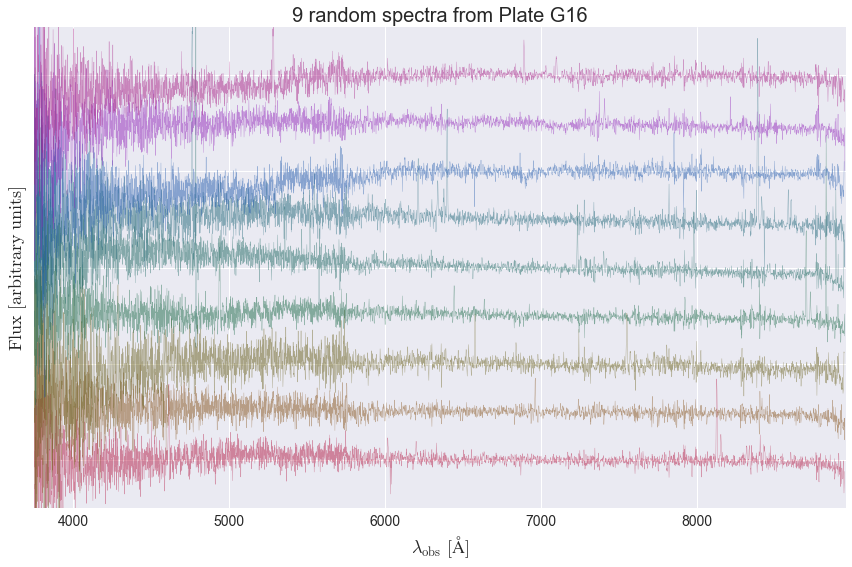

In [8]:
# prepare for the plotting
fig = plt.figure(figsize=(12, 8))                                  
ax = fig.add_subplot(111)  

# some constants
N_fibers  = 400
N_spectra = 10

# offset the fluxes so that all of the spectra don't get stuck on top of each other
flux_offset = 100
count = 0

# shuffle around the 400 spectra for randomness
np.random.shuffle(spectra) 

# make a rainbow color palette                                              
color_palette = sns.husl_palette(N_spectra, l=0.4)

for spectrum, color in zip(spectra[::N_fibers / N_spectra], color_palette):
    # skip empty fibers
    if np.isnan(spectrum).all():                                        
                continue  
    
    # record the median flux between 6000-8000 angstroms in order to force offset
    median_flux = np.nanmedian(spectrum[(wavelengths > 6000.) &         
                                        (wavelengths < 8000.)]) 
    
    # plot each normalized spectrum
    ax.plot(wavelengths, spectrum - median_flux + flux_offset * count,
            lw=0.4, color = color, alpha=0.5)
    
    # increment the offset_index for each successful plot
    count += 1
    
# some last bit of housekeeping
sns.set(style = 'ticks')
ax.set_xlim(3750, 8950) 
ax.set_xlabel(r'$\lambda_{\rm obs}\ [\rm \AA]$', fontsize=18)                   

ax.set_ylim(-1 * flux_offset, count * flux_offset)
ax.set_ylabel(r'$\rm Flux \ [arbitrary\ units]}$', fontsize=18)
plt.setp(ax.get_yticklabels(),visible=False)  # hide y-axis numbers because they're not meaningful

ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_title('{} random spectra from Plate G16'.format(count), fontsize=20)      

plt.tight_layout()

## IV. Extracting galaxy redshifts

The observed spectra have also been redshifted and classified by using the [Marz program](http://samreay.github.io/Marz/). Those results are concatenated into a single master catalog in the *comma separated value*, or CSV, format. I primarily use two tools to read in these tables: [`numpy.genfromtxt`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.genfromtxt.html) and [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). The first function simply loads the catalog into an array, whereas the second is actually a class/object that handles columns, rows, etc.

The `numpy.genfromtxt` and `numpy.loadtxt` functions are slightly more versatile because they return *n*-dimensional arrays (ndarrays). In fact, the `astropy` library retrieved our spectra in the ndarray format. We can load in the data via `numpy` (or `np` as shortened) by executing the following code, for example:

    galaxies = np.genfromtxt(filepath, delimiter=',', skip_header=2, autostrip=True, names=True, dtype=None)
    good_detections = galaxies[(galaxies['QOP'] == 3) & (galaxies['QOP'] == 4)]

Below, I'll go the other route and read in the Marz-reduced catalog by using the **DataFrame** object, and display some information.

In [9]:
import pandas as pd

galaxies = pd.read_csv('../aat_2015/laduma_2015_master.marz.cat',
                       delimiter = ',',
                       usecols = (1, 2, 3, 4, 11, 12, 13),
                       names = ('ID', 'ra', 'dec', 'r', 'morphology', 'z', 'QOP'),
                       index_col = 'ID')

print 'Here are some summary statistics:'
galaxies.describe()

Here are some summary statistics:


/usr/lib/python2.7/dist-packages/pandas/compat/scipy.py:68: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  score = values[idx]


,ra,dec,r,z,QOP
count,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000
mean,0.927550,-0.490676,19.872434,0.400270,2.901334
std,0.010979,0.009592,0.695018,0.670524,1.190565
min,0.906604,-0.509271,17.000000,-0.016010,1.000000
25%,0.918534,-0.498787,19.780000,0.164170,2.000000
50%,0.926847,-0.490193,20.140000,0.271870,3.000000
75%,0.937302,-0.482271,20.350000,0.353190,4.000000
max,0.947978,-0.472686,20.890000,4.721060,6.000000


In [10]:
print 'And here are the first five rows of all the columns:'
galaxies.head()

And here are the first five rows of all the columns:


,ra,dec,r,morphology,z,QOP
ID,,,,,,
R153347,0.943728,-0.491616,19.69,Transitional Galaxy,0.20445,4
R196117,0.947695,-0.491849,20.18,Transitional Galaxy,0.07861,3
R196130,0.945242,-0.491819,20.00,Composite Galaxy,0.23130,4
V278617,0.936957,-0.490050,18.48,Late Type Emission Galaxy,0.06649,4
R184495,0.941447,-0.491977,20.39,Transitional Galaxy,0.33990,4


The right ascension (RA) and declination (Dec) are the coordinates of each galaxy, both given in units of degrees. The $r$-band magnitude ($m_r$) is also listed where $r$ relates to the observed flux, $F_r$, and the zero-point flux, $F_{r,0}$: $$ m_r = -2.5 \log_{10}\bigg ( \frac{F_r}{F_{r,0}} \bigg). $$

Other columns show the derived redshift ($z$), the ID (or object name), and derived morphology of the galaxy/object. Finally, QOP is listed; QOP is a quality flag whereby values of 1, 2, 3, 4, 6 correspond to poor, okay, good, excellent, and star. For the most part, we will not want to use poor/okay spectral fits, and we want to exclude stars since we will be studying other galaxies.

Below I'll plot the $r$ versus $z$ distributions of the high-confidence galaxies.

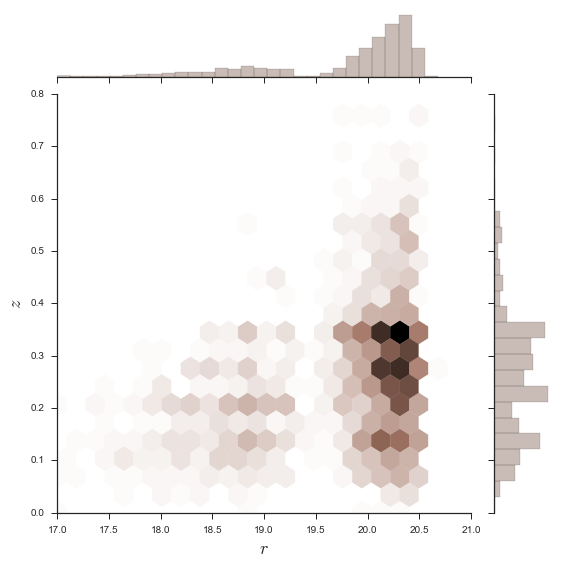

In [11]:
# exclude stars and only keep good fits
gals = galaxies[(galaxies['QOP'] == 4) | (galaxies['QOP'] == 3)]

# clip galaxies with z > 0.8 because they'll stretch out our plot
gals = gals[gals['z'] <= 0.8]

# plot galaxies in space of r-magnitude versus redshift
sns.set(style = 'ticks')
g = sns.jointplot(x='r', y='z', data=gals, kind='hex', gridsize=20, stat_func=None,
                  xlim=(17.0, 21.0), ylim=(0.0, 0.8), color='#795548', size=8)

g.set_axis_labels(r'$r$', r'$z$', fontsize = 18)

plt.tight_layout()

## Footnotes

<sup><a name="1">1</a></sup>The AAT houses the 4m telescope mirror. The 2dF instrument allocates up to 400 (actually 392) fibers, each of which is centered on an astronomical object, and feeds the signal into the AAOmega spectrograph. If you'd like to learn more about the AAT/2dF+AAOmega hardware and stuff, you can read the [manual](https://www.aao.gov.au/science/instruments/current/AAOmega/manual).

<sup><a name="2">2</a></sup>The python convention of row-major order can be confusing when working with images as well. Because the rows increment on the `y` axis, images pixels are then labeled `image[y, x]`, which can be counter-intuitive. Another difference between FITS/Fortran/MATLAB and Python/C/C++ is that the former are 1-indexed (i.e., the first element is labeled as index 1) and that the latter are 0-indexed (i.e., the first element is labeled as index 0).